In [112]:
import torch
import torch.nn as nn

import numpy as np

import matplotlib.pyplot as plt

import word2vec
from data_loader import load_data

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from utils import plot_confusion_matrix
from utils import timeSince

import time

In [113]:
dim_word2vec = 50

batch_size = 16
epochs = 5
learning_rate = 1e-4
model_fn = '../results/rnn_tc/rnn_tc_50d.11160425.pt'

In [114]:
# glov_wv = word2vec.load_wv('../data/word2vec/glove.twitter.27B/word2vec.%dd.txt' % dim_word2vec)
glov_wv = word2vec.load_wv_from_model('../data/word2vec/retrained_word2vec/reddit_word2vec')

loading word2vec...


In [115]:
data, labels = load_data('../data/data.csv')
data_train, data_test, label_train, label_test = train_test_split(data, labels, test_size=0.2, shuffle=True,stratify=labels)

In [116]:
#check number of labels in each class
tmp = label_test.tolist()
for label in np.unique(label_test):
    print('{}: {}'.format(label, tmp.count(label)))

tmp2 = label_train.tolist()
for label in np.unique(label_train):
    print('{}: {}'.format(label, tmp2.count(label)))

def avg_length(sentences):
    N = len(sentences)
    all_length = 0
    for sentence in sentences:
        all_length += len(sentence)

    return all_length / N    

def txt2vector(sentences, dic, dim, pad_length=14):
    vectors = []
    count = 0
    
    for sentence in sentences:
        vector = []
        for word in word2vec.preprocess(sentence[0]):
            if len(vector) <= pad_length and word in dic:
                vector.append(dic[word])
            
            if word not in dic:
                count += 1
        
        while len(vector) <= pad_length:
            vector.append(np.ones(dim))
            
        vectors.append(vector)
        
    print('missing words: %d, avg missing words: %f' % (count, count / sentences.shape[0]))
    return np.array(vectors)

data_train_vec = txt2vector(data_train, glov_wv, dim_word2vec, 15)
data_test_vec = txt2vector(data_test, glov_wv, dim_word2vec, 15)

all_categories = np.unique(labels).tolist()
print('categories:', all_categories)

def label2vector(labels, all_categories):
    return np.array([all_categories.index(label) for label in labels])

label_train_vec = label2vector(label_train, all_categories)
label_test_vec = label2vector(label_test, all_categories)

education: 1016
politics: 1084
science: 1036
sports: 1000
education: 4065
politics: 4333
science: 4142
sports: 4000
missing words: 22750, avg missing words: 1.375453
missing words: 5542, avg missing words: 1.339942
categories: ['education', 'politics', 'science', 'sports']


In [117]:
data_train_vec.shape, data_test_vec.shape, label_train_vec.shape

((16540, 16, 50), (4136, 16, 50), (16540,))

In [118]:
def batch_iter(X, y, batch_size=64, shuffle=True):
    N = len(X)
    num_batch = int((N - 1) / batch_size) + 1
    
    if shuffle:
        indices = np.random.permutation(np.arange(N))
        X_shuffle = X[indices]
        y_shuffle = y[indices]
    else:
        X_shuffle = X
        y_shuffle = y
    
    for i in range(num_batch):
        start_idx = i * batch_size
        end_idx = min((i+1) * batch_size, N)
        yield X_shuffle[start_idx: end_idx], y_shuffle[start_idx: end_idx]

In [119]:
n_class = len(all_categories)
n_training = len(data_train)

In [120]:
class RNN_tc(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_tc, self).__init__()
        self.num_layer = 1
        self.num_directions = 1
        
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)        
        self.i2o = nn.Linear(hidden_size, output_size)        
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden):
        output, hidden = self.rnn(input, hidden)     
        output = self.i2o(output[:, -1, :])     
        output = self.softmax(output)   
        return output, hidden
    
    def initHidden(self, batch_size):
        return torch.zeros(self.num_layer*self.num_directions ,batch_size, self.hidden_size)

In [122]:
model = RNN_tc(dim_word2vec, 200, n_class)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
criterion = nn.NLLLoss()

losses = []

start = time.time()
min_loss = 1e+5

# test = 0

for epoch in range(epochs):
#     scheduler.step()
    idx = 0
    for X_batch, y_batch in batch_iter(data_train_vec, label_train_vec, batch_size):
        X_batch = torch.tensor(X_batch, dtype=torch.float)
        y_batch = torch.tensor(y_batch)
        
        cur_batch_size = y_batch.size()[0]
        
        hidden = model.initHidden(cur_batch_size)        
        output, hidden = model(X_batch, hidden)
        loss = criterion(output, y_batch)

        optimizer.zero_grad()
        loss.backward(retain_graph=True)        
        optimizer.step()        
        
        if loss.item() < min_loss:
            min_loss = loss.item()
            torch.save(model, model_fn)
        
        idx += 1
        
        if idx % 100 == 0:
            losses.append(loss.item())
            print('%s, %d epoch, %d index, %f loss' % (timeSince(start),epoch, idx, loss.item()))            
        

/Users/zhengcao/anaconda3/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type RNN_tc. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0m 0s, 0 epoch, 100 index, 1.359987 loss
0m 1s, 0 epoch, 200 index, 1.058396 loss
0m 1s, 0 epoch, 300 index, 0.754912 loss
0m 2s, 0 epoch, 400 index, 0.790463 loss
0m 3s, 0 epoch, 500 index, 0.519766 loss
0m 3s, 0 epoch, 600 index, 0.346228 loss
0m 4s, 0 epoch, 700 index, 0.303462 loss
0m 5s, 0 epoch, 800 index, 0.174790 loss
0m 5s, 0 epoch, 900 index, 0.216088 loss
0m 6s, 0 epoch, 1000 index, 0.266841 loss
0m 7s, 1 epoch, 100 index, 0.170198 loss
0m 7s, 1 epoch, 200 index, 0.128011 loss
0m 8s, 1 epoch, 300 index, 0.331760 loss
0m 8s, 1 epoch, 400 index, 0.249096 loss
0m 9s, 1 epoch, 500 index, 0.498649 loss
0m 9s, 1 epoch, 600 index, 0.284910 loss
0m 10s, 1 epoch, 700 index, 0.230832 loss
0m 11s, 1 epoch, 800 index, 0.566946 loss
0m 11s, 1 epoch, 900 index, 0.116255 loss
0m 12s, 1 epoch, 1000 index, 0.076228 loss
0m 12s, 2 epoch, 100 index, 0.316399 loss
0m 13s, 2 epoch, 200 index, 0.571238 loss
0m 13s, 2 epoch, 300 index, 0.064314 loss
0m 14s, 2 epoch, 400 index, 0.683879 loss
0m 14s

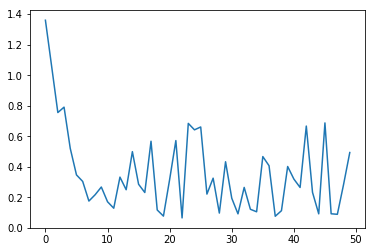

In [123]:
plt.figure()
plt.plot(np.arange(len(losses)), losses)
plt.show()

Confusion matrix, without normalization
[[939  30  34  13]
 [ 46 997  19  22]
 [ 50  21 948  17]
 [ 33  38  23 906]]


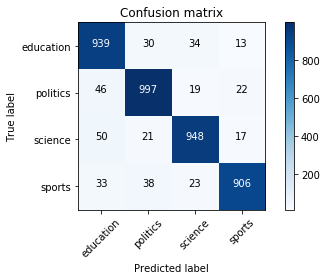

              precision    recall  f1-score   support

   education       0.88      0.92      0.90      1016
    politics       0.92      0.92      0.92      1084
     science       0.93      0.92      0.92      1036
      sports       0.95      0.91      0.93      1000

   micro avg       0.92      0.92      0.92      4136
   macro avg       0.92      0.92      0.92      4136
weighted avg       0.92      0.92      0.92      4136



In [124]:
def category_from_output(output, all_categories):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i]

y_preds = []
for X_batch, y_batch in batch_iter(data_test_vec, label_test_vec, 1, False):
    X_batch = torch.tensor(X_batch, dtype=torch.float)
    y_batch = torch.tensor(y_batch)
    
    cur_batch_size = y_batch.size()[0]    
    
    hidden = model.initHidden(cur_batch_size)        
    output, hidden = model(X_batch, hidden)    

    for r in output:
        y_preds.append(category_from_output(r, all_categories))

cnf_matrix = confusion_matrix(label_test, y_preds)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=all_categories, title='Confusion matrix')
plt.show()

print(classification_report(label_test, y_preds))